<a href="https://colab.research.google.com/github/scpepper69/ml-learning-materials/blob/master/TensorFlow_Keras_LSTM_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI・機械学習 勉強会 #3
## - LSTMを用いた時系列データの予測 -


## 目次

  
3.1.   概要

3.2.   実装プロセス

1.   LSTM概要
2.   環境準備
3.   データの準備
4.   学習に向けたデータの変換
5.   モデル構築
6.   モデルの学習
7.   予測結果の確認
8.   モデルの保存


---
##3.1 概要
代表的なRNN(Recurrent Neural Network)である、LSTM(Long-Short Term Memory)を用いて、時系列データの予測モデルを構築します。





---



## 3.2 実装プロセス

今回は、時系列データとして、株価を用います。

日本の自動車メーカー5社の株価の遷移をデータ化したものを用意しました。

LSTMを用いて株価予測がどの程度の精度を出せるか検証してみたいと思います。



### 3.2.1 LSTM概要

少しだけ、LSTMのモデル構造について、触れておきます。

詳細な説明はWeb上で多くの記事で紹介されていますので、ここではRNNのイメージとLSTMの特徴のみの紹介とします。

LSTMはRNN(リカレントニューラルネットワーク)の改善版として発明されたモデルです。

RNNのモデル構造は以下の形で表現されます。

<br>
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width=400>
<br><br>

時系列に並んだ入力データⓍごとに出力ⓗを行うととも、出力のコピーを次のレイヤーに受け渡しています。

こうすることで、データのつながりを意識した学習を実現しています。

<br>
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width=400>
<br><br>

上記は旧来のRNNにおける個別レイヤーの中身を表現した図となります。

活性化関数は一般的にはtanhを用います。

<br>
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width=400>
<br><br>

上記はLSTMの個別レイヤーの中身となります。

特徴としては下記3点あります。

- 前レイヤーからのデータの受け渡しが2か所(上段が長期記憶、下段が短期記憶)になっている
- 入力、出力にそれぞれゲート(Sigmoid)が用意されている
- 長期記憶のインプットに忘却ゲートが用意されている

これら実装によって、旧来RNNの弱点であった、系列データ数の限界を取り除き、かつ精度の向上を実現しています。

<br>

(画像引用元: http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### 3.2.2 環境準備

ここから、実際に動かしていきます。まずは、必要なライブラリをインポートします。

LSTMのモデル構築にあたり、ここではKerasを用います。

KerasではLSTMがライブラリとして実装されており、これを呼び出すだけでモデル構築が可能になっています。







In [48]:
!wget https://raw.githubusercontent.com/intel-analytics/analytics-zoo/master/pyzoo/zoo/util/tf_graph_util.py

import numpy
import matplotlib.pyplot as plt
import pandas
import math
import tensorflow as tf
from tensorflow.python.framework import graph_io
import tf_graph_util as graph_util
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


--2019-09-27 06:12:33--  https://raw.githubusercontent.com/intel-analytics/analytics-zoo/master/pyzoo/zoo/util/tf_graph_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19584 (19K) [text/plain]
Saving to: ‘tf_graph_util.py.2’

tf_graph_util.py.2  100%[===================>]  19.12K  --.-KB/s    in 0.001s  

2019-09-27 06:12:33 (31.9 MB/s) - ‘tf_graph_util.py.2’ saved [19584/19584]



### 3.2.3 データの準備

株価予測にあたってのトレーニング用データ、検証データを準備します。

本Note Bookと同一のGitHubリポジトリにサンプルデータ(2017年1月から、現在までの日次の終値)を用意していますので、今回はこちらを使います。

データをダウンロードし、データの中身を見てみましょう。

なお、元のcsv上には日付も保持していますが、ここでは休日を無視した、連続データとして使用します。

--2019-09-27 06:12:35--  https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/stock_auto_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24980 (24K) [text/plain]
Saving to: ‘stock_auto_data.csv.2’

stock_auto_data.csv 100%[===================>]  24.39K  --.-KB/s    in 0s      

2019-09-27 06:12:35 (47.9 MB/s) - ‘stock_auto_data.csv.2’ saved [24980/24980]



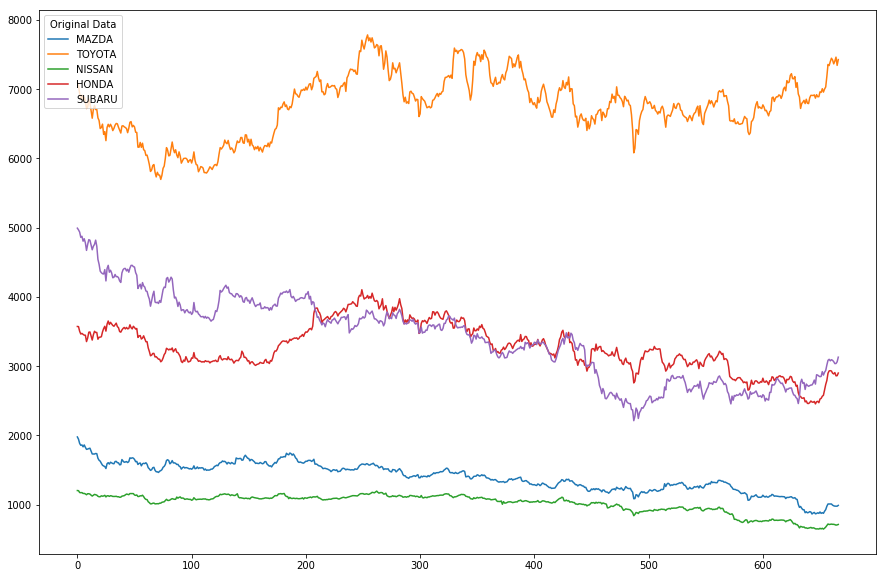

In [49]:
# 予測対象のサンプルデータを取得
!wget https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/stock_auto_data.csv


dataframe = pandas.read_csv('./stock_auto_data.csv', usecols=[1,2,3,4,5], engine='python', skipfooter=0).iloc[:,[2,1,0,3,4]]
#dataframe = pandas.read_csv('./stock_auto_data.csv', usecols=[3,5], engine='python', skipfooter=0)
#dataframe = pandas.read_csv('./stock_auto_data.csv', usecols=[3], engine='python', skipfooter=0)
#print(dataframe.head())

legend_list = ["MAZDA","TOYOTA","NISSAN","HONDA","SUBARU"]
#legend_list = ["MAZDA","HONDA"]

plt.figure(figsize=(15, 10))
p1 = plt.plot(dataframe)
l1 = plt.legend(p1,legend_list, loc='upper left', title='Original Data')

plt.show()

データに大小のばらつきが大きい場合、値の大きさでデータの重要度が判断されてしまうと、適切な学習ができなくなります。

変動幅を学習することがポイントとなるため、データを0から1までの数値に正規化します。

データの正規化に際しては、sklearnのMinMaxScalerクラスを用いて簡単に実装できます。

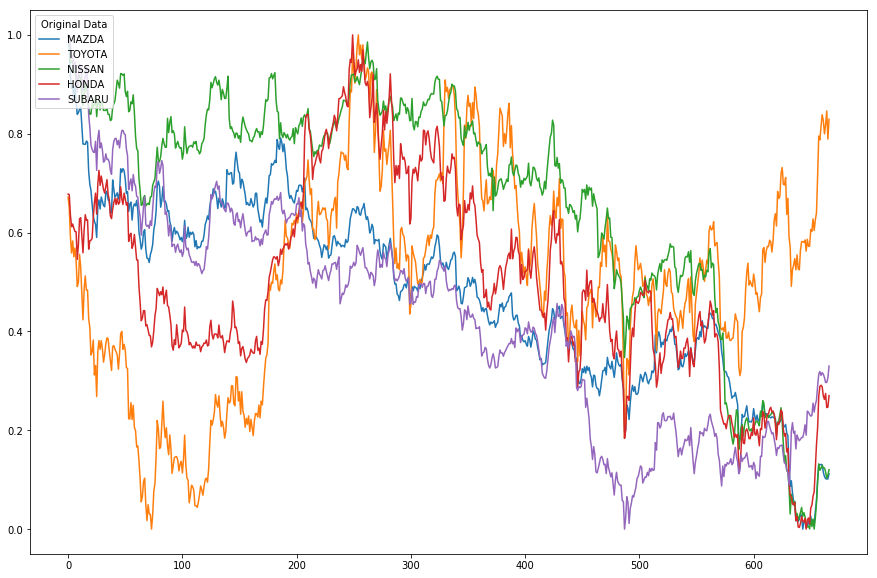

In [50]:
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = dataset.astype('float32')

plt.figure(figsize=(15, 10))
plt.plot(dataset)
plt.legend(p1,legend_list ,loc='upper left', title='Original Data')
plt.show()


### 3.2.4 学習に向けたデータの変換

学習に用いる教師データは、過去数日(look_back変数指定値)の実績データに対して、翌営業日の正解ラベルを持たせる形式とします。

以下はloop_back=15の場合の教師データと正解ラベルの関連性について示しています。
<br>
<img src="https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/images/lstm_data.png" width=600>
<br><br>




In [0]:
# 教師データの保持単位
look_back = 15

# 検証データとして使用する日数(学習用から除外)
val_days = 180

まずは、データを学習用データと、検証用データに分割します。

時系列予測の場合は、時系列であることを維持して分割してやる必要があります。

データの構成は下記のようになります。

- 学習用データ：全データの最も古い日付から、全データの最新日付 - (val_daysで指定した日数 + 1)
- 検証用データ：学習用データの最新日付 - look_backで指定した日数から、全データの最新日付

In [52]:
# 学習用データと検証用データに分割
train_size = int(len(dataset) -val_days -1)
train, test = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]
#print(len(dataset), len(train), len(test))

date_check = pandas.read_csv('./stock_auto_data.csv', usecols=[0], engine='python', skipfooter=0).values
train_first_date = str(date_check[0]).replace('/','-')
train_last_date = str(date_check[train_size]).replace('/','-')
test_first_date = str(date_check[train_size-look_back]).replace('/','-')
test_last_date = str(date_check[len(dataset)-1]).replace('/','-')

print('学習用データ：' + train_first_date,train_last_date)
print('検証用データ：' + test_first_date,test_last_date)

学習用データ：['2017-1-4'] ['2018-12-21']
検証用データ：['2018-11-30'] ['2019-09-26']


In [53]:
# 正解ラベルと教師データの紐づけを実施
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    #for i in range(len(dataset)-look_back-1):
    for i in range(len(dataset)-look_back):
        xset = []
        yset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
            b = dataset[i + look_back, j] #add
            yset.append(b) #add
        #dataY.append(dataset[i + look_back, 0])
        dataX.append(xset)
        dataY.append(yset) #add
    return numpy.array(dataX), numpy.array(dataY)

def create_dataset_ex(dataset, look_back=30, target_col=0):
    dataX, dataY = [], []
    #for i in range(len(dataset)-look_back-1):
    for i in range(len(dataset)-look_back):
        xset = []
        yset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
            if j == target_col:
                b = dataset[i + look_back, j] #add
                yset.append(b) #add
        #dataY.append(dataset[i + look_back, 0])
        dataX.append(xset)
        dataY.append(yset) #add
    return numpy.array(dataX), numpy.array(dataY)



# reshape into X=t and Y=t+1
trainX, trainY = create_dataset_ex(train, look_back)
testX, testY = create_dataset_ex(test, look_back)
print(f"学習用教師データ {trainX.shape}")
print(f"学習用正解ラベル {trainY.shape}")
print(f"検証用教師データ {testX.shape}")
print(f"検証用正解ラベル {testY.shape}")


学習用教師データ (471, 5, 15)
学習用正解ラベル (471, 1)
検証用教師データ (181, 5, 15)
検証用正解ラベル (181, 1)


In [0]:
# reshape input to be [samples, time steps(number of variables), features] *convert time series into column
#trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
#testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
#print(trainX.shape)
#print(testX.shape)

### 3.2.5 モデルの構築

Kerasでは、非常に簡単にLSTMモデルを構築することができます。

[Keraas Document LSTM](https://keras.io/ja/layers/recurrent/#lstm)

単純なデータであるため、シンプルなLSTMでも十分な結果が得られると思いますが、敢えてLSTMを重ねた実装(Stacked LSTM)をしてみます。


In [55]:
# LSTMモデルの構築
model = Sequential()
#model.add(LSTM(400, input_shape=(trainX.shape[1], look_back))) #shape：variables,loopback time
model.add(LSTM(256, return_sequences=True, input_shape=(trainX.shape[1], look_back))) #shape：variables,loopback time
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256))
model.add(BatchNormalization())
model.add(Dense(trainY.shape[1])) # dimension count
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 256)            278528    
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 1,330,433
Trainable params: 1,329,921
Non-trainable params: 512
_________________________________________________________________


モデル構造を図示します。今回はKerasに備わっているplot_modelというツールを用います。


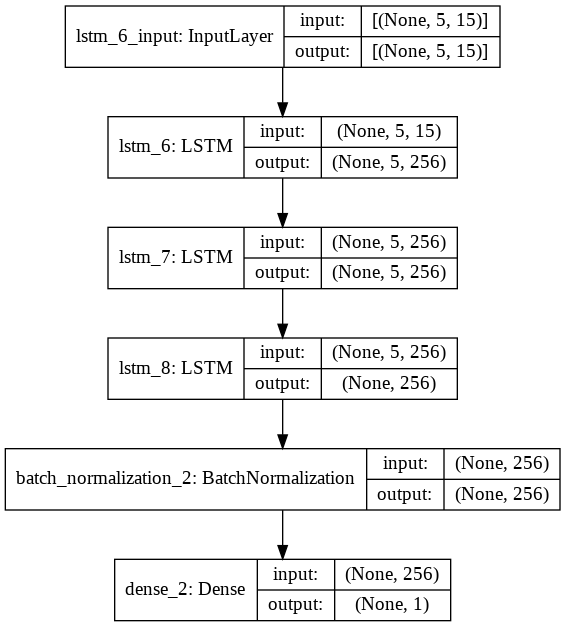

In [56]:
from tensorflow.python.keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="./model.png", show_shapes=True)
Image("./model.png")

### 3.2.6 モデルの学習

In [57]:
# エポック数の指定
epochs=100

# バッチサイズの指定
batch_size=16

# 学習の実行
model.fit(trainX, trainY, epochs=epochs, batch_size=16, verbose=2)


Epoch 1/100
471/471 - 3s - loss: 0.0404
Epoch 2/100
471/471 - 1s - loss: 0.0138
Epoch 3/100
471/471 - 1s - loss: 0.0134
Epoch 4/100
471/471 - 1s - loss: 0.0136
Epoch 5/100
471/471 - 1s - loss: 0.0137
Epoch 6/100
471/471 - 1s - loss: 0.0132
Epoch 7/100
471/471 - 1s - loss: 0.0134
Epoch 8/100
471/471 - 1s - loss: 0.0109
Epoch 9/100
471/471 - 1s - loss: 0.0050
Epoch 10/100
471/471 - 1s - loss: 0.0024
Epoch 11/100
471/471 - 1s - loss: 0.0014
Epoch 12/100
471/471 - 1s - loss: 0.0011
Epoch 13/100
471/471 - 1s - loss: 0.0013
Epoch 14/100
471/471 - 1s - loss: 0.0011
Epoch 15/100
471/471 - 1s - loss: 9.6608e-04
Epoch 16/100
471/471 - 1s - loss: 8.7390e-04
Epoch 17/100
471/471 - 1s - loss: 8.9616e-04
Epoch 18/100
471/471 - 1s - loss: 9.5895e-04
Epoch 19/100
471/471 - 1s - loss: 0.0011
Epoch 20/100
471/471 - 1s - loss: 8.7686e-04
Epoch 21/100
471/471 - 1s - loss: 8.5861e-04
Epoch 22/100
471/471 - 1s - loss: 0.0015
Epoch 23/100
471/471 - 1s - loss: 8.1701e-04
Epoch 24/100
471/471 - 1s - loss: 0.00

### 3.2.7 予測結果の確認

予測結果は、画像分類のCNNなどと同じようにmodel.predictにて取得することができます。

精度の確認のため、学習用データ、検証用データ双方の予測結果を取得しておきます。

In [58]:
# 予測結果の取得
trainPredict = model.predict(trainX, verbose=1)
testPredict = model.predict(testX, verbose=1)


181/181 [==============================] - 0s 359us/sample


上記で予測結果を取得できましたが、得られた結果は正規化した値になっており、元のスケールにデコードしてやる必要があります。

エンコード時とデコード時の配列構成が同じ場合、そのままinverse_transform関数を使うことができるのですが、

今回の実装においては、エンコード時とデコード時の配列の要素数が異なります。この場合、デコード対象のmin_およびscale_をエンコード時のクラスから抽出することで、正常にデコードすることが可能です。


In [0]:
#trainPredict = scaler.inverse_transform(pad_array(trainPredict))
#trainY = scaler.inverse_transform(pad_array(trainY))
#testPredict = scaler.inverse_transform(pad_array(testPredict))
#testY = scaler.inverse_transform(pad_array(testY))

scale=MinMaxScaler()
scale.min_,scale.scale_ = scaler.min_[0],scaler.scale_[0]

#scaled_trainPredict = scaler.inverse_transform(trainPredict)
#scaled_trainY = scaler.inverse_transform(trainY)
#scaled_testPredict = scaler.inverse_transform(testPredict)
#scaled_testY = scaler.inverse_transform(testY)

scaled_trainPredict = scale.inverse_transform(trainPredict)
scaled_trainY = scale.inverse_transform(trainY)
scaled_testPredict = scale.inverse_transform(testPredict)
scaled_testY = scale.inverse_transform(testY)

予測結果の精度を確認するため、二乗平均平方根誤差(RMSE)を算出します。

この値は、小さいほうが精度が高いことを示します。

当然のことながら、学習データは非常に良い精度を示しているかと思います。


In [60]:
# 二乗平均平方根誤差(RMSE)の取得
trainScore = math.sqrt(mean_squared_error(scaled_trainY[:,0], scaled_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaled_testY[:,0], scaled_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.38 RMSE
Test Score: 104.29 RMSE


検証用データと、その予測結果をプロットしてみます。

(668, 1)


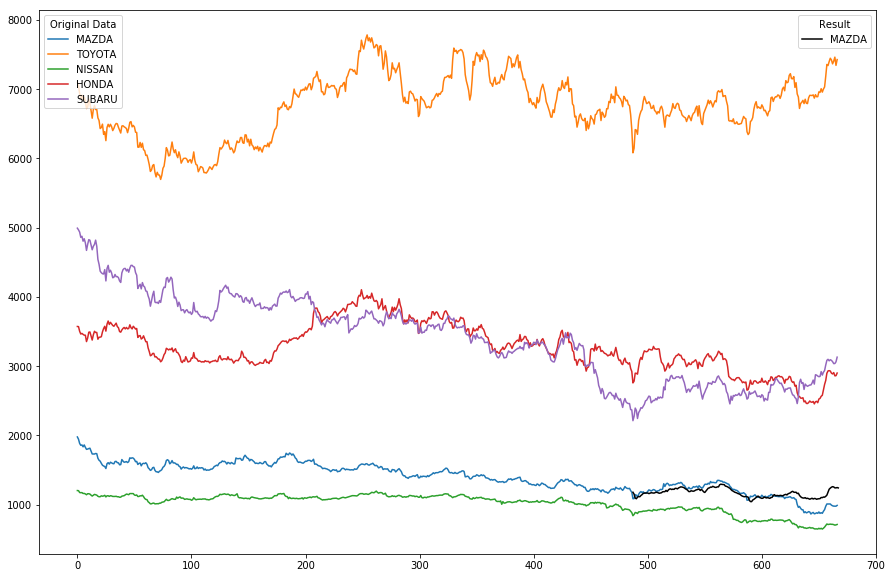

In [61]:
#print(testY[:,0])
#print(testPredict[:,0])
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(scaled_trainPredict)+look_back, :] = scaled_trainPredict
# shift test predictions for plotting
#testPredictPlot = numpy.empty_like(dataset)
testPredictPlot = numpy.empty((len(dataset)+1, trainY.shape[1]), dtype=numpy.float)
testPredictPlot[:, :] = numpy.nan
print(testPredictPlot.shape)
#testPredictPlot[len(scaled_trainPredict)+(look_back*2):len(dataset), :] = scaled_testPredict
testPredictPlot[len(dataset)-val_days:len(dataset)+1, :] = scaled_testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 10))
p1 = plt.plot(scaler.inverse_transform(dataset))
#p2 = plt.plot(trainPredictPlot)
p2 = plt.plot(testPredictPlot, color='black')
l1 = plt.legend(p1, legend_list, loc='upper left', title='Original Data')
l2 = plt.legend(p2, legend_list, loc='upper right', title='Result')

plt.gca().add_artist(l1) 
plt.show()
plt.close()

予測結果の部分のみを抽出して表示してみます。

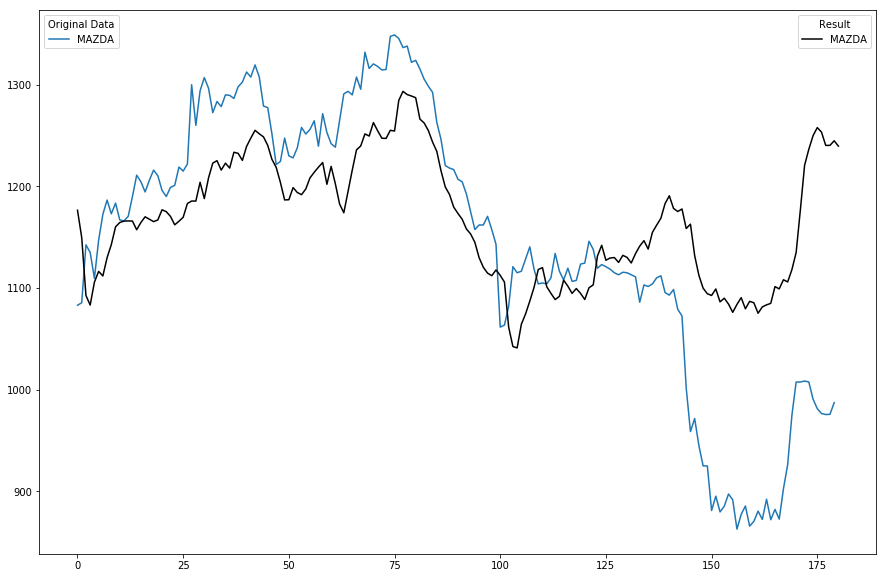

In [62]:
plt.figure(figsize=(15, 10))

p1 = plt.plot(dataframe.values[len(dataset)-val_days:len(dataset),0])
p2 = plt.plot(scaled_testPredict, color='black')

l1 = plt.legend(p1, legend_list, loc='upper left', title='Original Data')
l2 = plt.legend(p2, legend_list, loc='upper right', title='Result')

plt.gca().add_artist(l1) 
plt.show()
plt.close()

予測精度はいかがだったでしょうか。

結論を言ってしまうと、予測対象の銘柄のみを学習対象とした場合のほうが、精度としてはあっているように"見えます"。

ただし、これは正しく予測できているわけではなく、ただ、前日のデータの後追いをしているに過ぎない結果です。

株価の特性として、大幅な変動要素が少ない時系列データの場合、前日の後追いをすることが、無難な結果を導くことは容易に想像できるかと思います。Deep learningとしても同じ判断をした、ということになります。

一方、他銘柄を含んで学習を行った場合、他銘柄の変動状況も踏まえて判断していることが見えてくると思います。

とはいえ、結果だけを見れば予測精度としてはイマイチと言わざるを得ません。これは、結果を導く学習データが適切でない、ということを示しています。

目的の結果がどのような因果関係をもって作られているのかを理解し、その因果関係を持った構成要素をデータを収集することが重要である、ということです。

分かりやすい例だと、気候と電力消費といった因果関係の強いデータであれば、ある程度使える結果を導くことが可能でしょう。

### 3.2.8 モデルの保存

学習したモデルを再利用可能とするため、静的モデルとして保存しておきます。

実装内容については、「[TensorFlow_Keras_ImageClassificatioin_01](https://github.com/scpepper69/ml-learning-materials/blob/master/TensorFlow_Keras_ImageClassificatioin_01.ipynb)」で言及していますので、ここでは詳細触れません。

必要あれば、「[TensorFlow_Keras_ImageClassificatioin_01](https://github.com/scpepper69/ml-learning-materials/blob/master/TensorFlow_Keras_ImageClassificatioin_01.ipynb)」を見返してください。


In [63]:
K.set_learning_phase(0)
ksess = K.get_session()
#print(ksess)

#K.set_learning_phase(0)
graph = ksess.graph
kgraph = graph.as_graph_def()
print(kgraph)

output_names = [node.op.name for node in model.outputs]
freeze_var_names = list(set(v.op.name for v in tf.global_variables()))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [64]:
# fix batch norm nodes
for node in kgraph.node:
    if node.op == 'RefSwitch':
        node.op = 'Switch'
        for index in range(len(node.input)):
            if 'moving_' in node.input[index] and "Switch" not in node.input[index]:
                node.input[index] = node.input[index] + '/read'
    elif node.op == 'AssignSub':
        node.op = 'Sub'
        if 'use_locking' in node.attr: del node.attr['use_locking']
    elif node.op == 'AssignAdd':
        node.op = 'Add'
        if 'use_locking' in node.attr: del node.attr['use_locking']

# convert variables in the model graph to constants
constant_graph = graph_util.convert_variables_to_constants(ksess, kgraph, output_names)
#constant_graph = mod_graph_util.convert_variables_to_constants(ksess, kgraph, output_names)

output_dir = "./"
output_graph_name = "stock_auto.pb"
output_text_name = "stock_auto.txt"
graph_io.write_graph(constant_graph, output_dir, output_graph_name, as_text=False)
graph_io.write_graph(constant_graph, output_dir, output_text_name, as_text=True)

INFO:tensorflow:Froze 15 variables.
INFO:tensorflow:Converted 15 variables to const ops.


'./stock_auto.txt'